# MODEL TRAINING  USING THE PyTorch's API

This notebook is based on modular [shell scripts](./scripts) for convenience. The scripts comprise minimal lines of code (LOC), on average, no more than 10 LOC for each, making them easy to read, learn, and adapt for future applications.

**!!!Caveat :** 

Some scripts can be conveniently executed directly from this notebook, and some need to be executed in terminal to grant permissions. I recommend running each script from the terminal to see STDOUT clearly. If run in terminal, use the [module-training](./) directory as the working directory.

***This is an academic project. Interested developers are invited to freely contribute issues, questions, improvements, and discussions.***

---

## 1. CHECK SUBMODULES

[`check-submodules.sh`](./scripts/) makes sure that the [LabelImg](https://github.com/tzutalin/labelImg) and [TF models](https://github.com/tensorflow/models) submodule repositories are initialized correctly.

In [2]:
!./scripts/check-submodules.sh

-- checking submodules


## 2. CREATE VIRTUAL ENVIRONMENT

[`venv.sh`](./scripts/) creates a virtual environment and installs essential [apt](./resources/apt.txt) and [pip](./resources/pip.txt) dependencies  [( see dependencies.sh )](./scripts/).Depending on your system, you may still need to install more dependencies in addition to yolov5's and labelImg's dependencies! The script should be executed from the terminal. This is necessary to grant install permissions. The default name of the virtual environment is **venv**. This name can, of course, be changed by simply passing a single argument representative of the name you want. From the working directory run 



```
./scripts/venv.sh    
```

- *virtual environment named* `venv`

or 

```
./scripts/venv.sh my-venv-name 
```

- *virtual environment named* `my-venv-name`

---

## 3. TEST SETUP USING [EXAMPLE IN YOLOv5 DOCS](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/everett/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-9-3 torch 1.9.0+cu111 CUDA:0 (GeForce RTX 2070 SUPER, 7974.3125MB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 720x1280 2 persons, 2 ties
Speed: 617.5ms pre-process, 7.4ms inference, 0.9ms NMS per image at shape (1, 3, 384, 640)


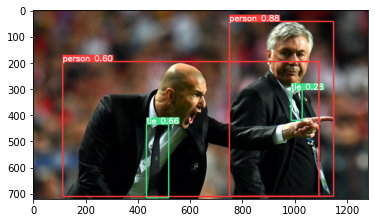

In [5]:
import uuid  
import os
import cv2
import time
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

# test with *s model (https://github.com/ultralytics/yolov5#pretrained-checkpoints)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True); 
img = 'https://ultralytics.com/images/zidane.jpg'
results = model(img)
results.print()


plt.imshow(np.squeeze(results.render()))
plt.show()
#results.render()

## 4. Create [dataset.yaml spec](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#1-create-datasetyaml) in the root directory of [Yolov5s' submodule directory](./external/yolov5) 

For this project, dataset.yaml looks like this

```
path: ../../resources/images
train: train
val: train

nc: 1  # number of classes
names: [ 'mobile device' ] # class  names

```

**!!!Caveat :** 

Also ensure to honor the location of the `labels` directory. It **must** exist in the same directory as the `images` directory (or whatever the directory's name where your training images are. The `labels` directory structure **must** also mirror the directory structure of the `images directory`!

---

## 4. [TRAIN](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data) CUSTOM MODEL 

Training speces for this project are as follows

* image size—320
* batch—16
* epochs—1200 
* weights—[yolov5m](https://github.com/ultralytics/yolov5#pretrained-checkpoints)
* workers—5

---

In [ ]:
!cd external/yolov5 && python3 train.py --img 320 --batch 16 --epochs 10 --data dataset.yaml --weights yolov5m.pt --workers 5

## 5. TEST TRAINED MODEL

---

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/everett/.cache/torch/hub/master.zip
YOLOv5 🚀 2021-9-4 torch 1.9.0+cu111 CUDA:0 (GeForce RTX 2070 SUPER, 7974.3125MB)

Fusing layers... 
Model Summary: 308 layers, 21037638 parameters, 0 gradients, 50.3 GFLOPs
Adding AutoShape... 
image 1/1: 576x640 4 mobile devices
Speed: 10.9ms pre-process, 12.3ms inference, 0.9ms NMS per image at shape (1, 3, 576, 640)


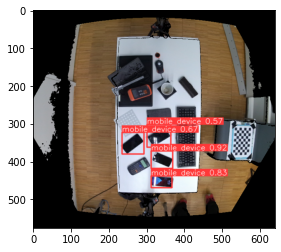

True

In [40]:
custom_model = torch.hub.load('ultralytics/yolov5', 'custom', path='external/yolov5/runs/train/exp21/weights/best.pt', force_reload=True)

img = 'resources/images/train/27_scene.png'
results = custom_model(img)
results.print()

frame = np.squeeze(results.render())
plt.imshow(np.squeeze(results.render()))

plt.show()
cv2.imwrite("./output/detected_objects.png", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [33]:
cap = cv2.VideoCapture(2)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Make detections 
    results = custom_model(frame)
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()